AI-QSAR model for carcinogenicity: single task classification model

Author: Chi-Yun Chen; Supervisor: Zhoumeng Lin; Date created: Apr.18.2025

Description: F1-optimized QSAR models (The best model files should be obtained in advance)

##Install necessary libraries

In [ ]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Install python pacakges
!pip install -q rdkit-pypi==2023.3.1b1
!pip install scikit-optimize==0.10.2
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#Install basic python pcakges
import pandas as pd
import numpy as np
import seaborn as sns
import time

# Molecular Descriptors Calculation
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, DataStructs
from rdkit.DataStructs import ExplicitBitVect
from rdkit.ML.Descriptors import MoleculeDescriptors

# Modeling
from sklearn.preprocessing import MinMaxScaler        # Feature scaling for RDKit descriptors
from sklearn.decomposition import PCA

##Import the data set

In [ ]:
df = pd.read_csv('SMILES_cancer df.csv')

# Split dataframe to X and y
Separate X into CAS and in vitro assays

In [ ]:
# Y label: Organ systems
# Extracting the second to the tenth columns (index 1 to 9)
Y = df.iloc[:, 1:11]
Y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957 entries, 0 to 956
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Alimentary system       957 non-null    int64
 1   Endocrine system        957 non-null    int64
 2   Exocrine system         957 non-null    int64
 3   Haematolymphoid system  957 non-null    int64
 4   Hepatobiliary system    957 non-null    int64
 5   Reproductive system     957 non-null    int64
 6   Respiratory system      957 non-null    int64
 7   Skin and soft tissue    957 non-null    int64
 8   Special Senses System   957 non-null    int64
 9   Urinary system          957 non-null    int64
dtypes: int64(10)
memory usage: 74.9 KB


In [ ]:
duplicates = df[df.duplicated(subset='SMILES', keep=False)]

In [ ]:
# Outcomes show 12 chemicals with 5 duplicates, therefore 957 compounds --> 950 unique compounds

# Check and remove the Y of duplicate SMILES
Since these duplicates contain different y and in vitro data, we need to remove all the duplicated chemicals (n = 12) from the original dataframe

In [ ]:
# Filter out rows from df where the SMILES column matches any SMILES in duplicates
df_finalized = df[~df['CAS'].isin(duplicates['CAS'])]
df_finalized = df_finalized.reset_index(drop=True)
df_finalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 84 columns):
 #   Column                                             Non-Null Count  Dtype 
---  ------                                             --------------  ----- 
 0   CAS                                                945 non-null    object
 1   Alimentary system                                  945 non-null    int64 
 2   Endocrine system                                   945 non-null    int64 
 3   Exocrine system                                    945 non-null    int64 
 4   Haematolymphoid system                             945 non-null    int64 
 5   Hepatobiliary system                               945 non-null    int64 
 6   Reproductive system                                945 non-null    int64 
 7   Respiratory system                                 945 non-null    int64 
 8   Skin and soft tissue                               945 non-null    int64 
 9   Special Senses System

# Fingerprints preparing

In [ ]:
# Define a function that transforms SMILES string into 2D RDKIT descriptors
def cal_rdkit_descr(smiles):
    mols = [Chem.MolFromSmiles(i) for i in smiles]
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
    desc_names = calc.GetDescriptorNames()

    mol_descriptors = []
    for mol in mols:
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        mol_descriptors.append(descriptors)

    return pd.DataFrame(mol_descriptors, index=smiles, columns=["rdkit_" + str(i) for i in desc_names])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE) or--
# --the Extended-Connectivity Fingerprints (ECFP) descriptors (if use_features = FALSE)

def cal_ECFP6_descr(smiles,
            R = 3,               # no default value, usually set 2 for similarity search and 3 for machine learning
            nBits = 2**10, # nBits = 1024; default is 2048
            use_features = False,
            use_chirality = False):

   '''
   Inputs:
   - smiles...SMILES string of input compounds
   - R....Maximum radius of circular substructures--By using this radius parameter, we compute ECFP6 (the equivalent of radius 3)
   - nBits....number of bits, default is 2048. 1024 is also widely used.
   - use_features...if true then use pharmacophoric atom features (FCFPs), if false then use standard DAYLIGHT atom features (ECFP)
   - use_chirality...if true then append tetrahedral chirality flags to atom features
   Outputs:
   - pd.DataFrame...ECFP or FCFPs with length nBits and maximum radus R

   '''
   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   ecfp_descriptors = []
   for mol in mols:
        ecfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(ecfp, array)
        ecfp_descriptors.append(ecfp)

   return pd.DataFrame([list(l) for l in ecfp_descriptors], index = smiles, columns=[f'ECFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an FCFP (if use_features = TRUE)
def cal_FCFP6_descr(smiles,
            R = 3,
            nBits = 2**10, # nBits = 1024
            use_features = True,
            use_chirality = False):

   mols = [AllChem.MolFromSmiles(i) for i in smiles]

   fcfp_descriptors = []
   for mol in mols:
        fcfp = AllChem.GetMorganFingerprintAsBitVect(mol,
                                radius = R,
                                nBits = nBits,
                                useFeatures = use_features,
                                useChirality = use_chirality)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fcfp, array)
        fcfp_descriptors.append(fcfp)

   return pd.DataFrame([list(l) for l in fcfp_descriptors], index = smiles, columns=[f'FCFP6_Bit_{i}' for i in range(nBits)])


# Define a function that transforms a SMILES string into an MACCS fingerprints

def cal_MACCS_descr(smiles):

   mols = [Chem.MolFromSmiles(i) for i in smiles]
   MACCS_descriptors = []
   for mol in mols:
        fp = MACCSkeys.GenMACCSKeys (mol)
        array = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(fp, array)
        MACCS_descriptors.append(fp)

   return pd.DataFrame([list(l) for l in MACCS_descriptors], index = smiles, columns=[f'MACCS_Bit_{i}' for i in range(167)])

In [ ]:
# Calculating RDKit descriptors
rdkit_descrs = cal_rdkit_descr(df_finalized['SMILES']).drop(['rdkit_MaxPartialCharge','rdkit_MinPartialCharge','rdkit_MaxAbsPartialCharge', 'rdkit_MinAbsPartialCharge', 'rdkit_BCUT2D_MWHI', 'rdkit_BCUT2D_MWLOW', 'rdkit_BCUT2D_CHGHI', 'rdkit_BCUT2D_CHGLO', 'rdkit_BCUT2D_LOGPHI', 'rdkit_BCUT2D_LOGPLOW', 'rdkit_BCUT2D_MRHI', 'rdkit_BCUT2D_MRLOW'], axis=1)
rdkit_descrs

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,7.814480,-0.628907,7.814480,0.054712,0.772870,249.107,240.035,247.983677,70,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,10.471720,-3.021449,10.471720,0.662247,0.617540,250.257,240.177,250.074228,92,0,...,0,0,0,0,0,0,0,0,0,0
[N+](=O)([O-])[O-].[Tl+],8.250000,-1.750000,8.250000,0.000000,0.333331,266.387,266.387,266.962245,26,2,...,0,0,0,0,0,0,0,0,0,0
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,8.818441,-2.713642,8.818441,0.418935,0.440550,389.320,384.280,385.816009,100,0,...,0,0,0,0,0,0,0,0,0,0
CC1=CC=C(C=C1)O,7.418449,-2.735790,7.418449,0.580556,0.535935,108.140,100.076,108.057515,42,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,10.684692,-1.071708,10.684692,0.159174,0.353370,153.141,146.085,153.053826,58,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,10.622830,-1.052150,10.622830,0.169954,0.271725,154.125,148.077,154.037842,58,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,10.755498,-3.059947,10.755498,0.269954,0.408307,168.152,160.088,168.053492,64,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Calculating ECFP6 fingerprints
ECFP6_descrs = cal_ECFP6_descr(df_finalized['SMILES'])
ECFP6_descrs

,ECFP6_Bit_0,ECFP6_Bit_1,ECFP6_Bit_2,ECFP6_Bit_3,ECFP6_Bit_4,ECFP6_Bit_5,ECFP6_Bit_6,ECFP6_Bit_7,ECFP6_Bit_8,ECFP6_Bit_9,...,ECFP6_Bit_1014,ECFP6_Bit_1015,ECFP6_Bit_1016,ECFP6_Bit_1017,ECFP6_Bit_1018,ECFP6_Bit_1019,ECFP6_Bit_1020,ECFP6_Bit_1021,ECFP6_Bit_1022,ECFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
[N+](=O)([O-])[O-].[Tl+],0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CC1=CC=C(C=C1)O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Calculating FCFP6 fingerprints
FCFP6_descrs = cal_FCFP6_descr(df_finalized['SMILES'])
FCFP6_descrs

,FCFP6_Bit_0,FCFP6_Bit_1,FCFP6_Bit_2,FCFP6_Bit_3,FCFP6_Bit_4,FCFP6_Bit_5,FCFP6_Bit_6,FCFP6_Bit_7,FCFP6_Bit_8,FCFP6_Bit_9,...,FCFP6_Bit_1014,FCFP6_Bit_1015,FCFP6_Bit_1016,FCFP6_Bit_1017,FCFP6_Bit_1018,FCFP6_Bit_1019,FCFP6_Bit_1020,FCFP6_Bit_1021,FCFP6_Bit_1022,FCFP6_Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,0,0,1,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
[N+](=O)([O-])[O-].[Tl+],1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,1,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
CC1=CC=C(C=C1)O,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,1,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# Calculating MACCS fingerprints
MACCS_descrs = cal_MACCS_descr(df_finalized['SMILES'])
MACCS_descrs

,MACCS_Bit_0,MACCS_Bit_1,MACCS_Bit_2,MACCS_Bit_3,MACCS_Bit_4,MACCS_Bit_5,MACCS_Bit_6,MACCS_Bit_7,MACCS_Bit_8,MACCS_Bit_9,...,MACCS_Bit_157,MACCS_Bit_158,MACCS_Bit_159,MACCS_Bit_160,MACCS_Bit_161,MACCS_Bit_162,MACCS_Bit_163,MACCS_Bit_164,MACCS_Bit_165,MACCS_Bit_166
SMILES,,,,,,,,,,,,,,,,,,,,,
C1=CC=C(C=C1)OC2=CC=C(C=C2)Br,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,1,0
C1=CC(=CC=C1CC2=CC=C(C=C2)N=C=O)N=C=O,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
[N+](=O)([O-])[O-].[Tl+],0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,1,0,1
C12C(C(C3C1O3)Cl)C4(C(=C(C2(C4(Cl)Cl)Cl)Cl)Cl)Cl,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,1,0
CC1=CC=C(C=C1)O,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C1=CC(=C(C=C1[N+](=O)[O-])N)N,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0
C1=CC(=C(C=C1[N+](=O)[O-])N)O,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
COC1=C(C=C(C=C1)[N+](=O)[O-])N,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0


# Feature scaling
Only RDKit descriptors are not binary

In [ ]:
# Applying feature scaling for RDKit descriptors
scaler = MinMaxScaler()
X_rdkit_descrs = rdkit_descrs
X_rdkit_descrs_scal = scaler.fit_transform(X_rdkit_descrs)
X_rdkit_descrs_scal = pd.DataFrame(X_rdkit_descrs_scal, columns = rdkit_descrs.columns.values.tolist())
X_rdkit_descrs_scal

,rdkit_MaxEStateIndex,rdkit_MinEStateIndex,rdkit_MaxAbsEStateIndex,rdkit_MinAbsEStateIndex,rdkit_qed,rdkit_MolWt,rdkit_HeavyAtomMolWt,rdkit_ExactMolWt,rdkit_NumValenceElectrons,rdkit_NumRadicalElectrons,...,rdkit_fr_sulfide,rdkit_fr_sulfonamd,rdkit_fr_sulfone,rdkit_fr_term_acetylene,rdkit_fr_tetrazole,rdkit_fr_thiazole,rdkit_fr_thiocyan,rdkit_fr_thiophene,rdkit_fr_unbrch_alkane,rdkit_fr_urea
0,0.252207,0.871866,0.252207,0.010834,0.816642,0.125322,0.125410,0.124737,0.099359,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.413434,0.688662,0.413434,0.131135,0.648200,0.126015,0.125498,0.125997,0.134615,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.278632,0.786021,0.278632,0.000000,0.339999,0.135731,0.141770,0.136176,0.028846,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.313122,0.712232,0.313122,0.082955,0.456269,0.209780,0.214961,0.207811,0.147436,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.228178,0.710536,0.228178,0.114959,0.559707,0.040410,0.038520,0.040401,0.054487,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,0.426356,0.837960,0.426356,0.031519,0.361730,0.067517,0.067084,0.067521,0.080128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.422603,0.839457,0.422603,0.033653,0.273193,0.068109,0.068321,0.068114,0.080128,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.430652,0.685714,0.430652,0.053455,0.421305,0.076559,0.075777,0.076562,0.089744,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.419172,0.701616,0.419172,0.159860,0.453409,0.057877,0.057149,0.057874,0.070513,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Single task
Yen_2d = df_finalized.loc[:, ['Endocrine system']]
Yex_2d = df_finalized.loc[:, ['Exocrine system']]
Yhe_2d = df_finalized.loc[:, ['Hepatobiliary system']]
Yres_2d = df_finalized.loc[:, ['Respiratory system']]
Yu_2d = df_finalized.loc[:, ['Urinary system']]

In [ ]:
# Convert Y as a column vector to a 1D array
Yen = Yen_2d.values.ravel()
Yex = Yex_2d.values.ravel()
Yhe = Yhe_2d.values.ravel()
Yres = Yres_2d.values.ravel()
Yu = Yu_2d.values.ravel()
print(Yen.shape)
print(Yex.shape)
print(Yhe.shape)
print(Yres.shape)
print(Yu.shape)

(945,)
(945,)
(945,)
(945,)
(945,)


## Scenario I: Include both types of features (molecular descriptor & in vitro data)

In [ ]:
# X features: in vitro assays
X_vitro = df_finalized.iloc[:, 11:82]
X_vitro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 71 columns):
 #   Column                                             Non-Null Count  Dtype
---  ------                                             --------------  -----
 0   tox21-ache-p3_ache-inhibitor_1                     945 non-null    int64
 1   tox21-ache-p5_ache-inhibitor_1                     945 non-null    int64
 2   tox21-ahr-p1_ahr-agonist_1                         945 non-null    int64
 3   tox21-ap1-agonist-p1_ap1-agonist_1                 945 non-null    int64
 4   tox21-ar-bla-agonist-p1_ar-agonist_1               945 non-null    int64
 5   tox21-ar-bla-antagonist-p1_ar-antagonist_1         945 non-null    int64
 6   tox21-are-bla-p1_nrf2-agonist_1                    945 non-null    int64
 7   tox21-aromatase-p1_aromatase-inhibitor_1           945 non-null    int64
 8   tox21-car-agonist-p1_car-agonist_1                 945 non-null    int64
 9   tox21-car-antagonist-p1_car-anta

In [ ]:
# Concatenating dataframes horizontally (along columns): TOX21 in vitro assays and descriptors
# X_rdkitTOX: X_vitro and X_rdkit_descrs_scal
X_rdkitTOX = pd.concat([X_vitro, X_rdkit_descrs_scal.reset_index(drop=True)], axis=1)
# X_ECFP6TOX: X_vitro and ECFP6_descrs
X_ECFP6TOX = pd.concat([X_vitro, ECFP6_descrs.reset_index(drop=True)], axis=1)
# X_FCFP6TOX: X_vitro and FCFP6_descrs
X_FCFP6TOX = pd.concat([X_vitro, FCFP6_descrs.reset_index(drop=True)], axis=1)
# X_MACCSTOX: X_vitro and MACCS_descrs
X_MACCSTOX = pd.concat([X_vitro, MACCS_descrs.reset_index(drop=True)], axis=1)
# X_AllTOX: X_vitro and four descriptors
X_AllTOX = pd.concat([X_vitro, X_rdkit_descrs_scal.reset_index(drop=True), ECFP6_descrs.reset_index(drop=True), FCFP6_descrs.reset_index(drop=True), MACCS_descrs.reset_index(drop=True)], axis = 1)

# Scenario II: Only molecular descriptor features as input

In [ ]:
# Only molecular descriptor features as input
# X_rdkit: RDKit
X_rdkit = X_rdkit_descrs_scal
# X_ECFP6: ECFP6_descrs
X_ECFP6 = ECFP6_descrs
# X_FCFP6: FCFP6_descrs
X_FCFP6 = FCFP6_descrs
# X_MACCS: MACCS_descrs
X_MACCS = MACCS_descrs
# X_All: four descriptors
X_All = pd.concat([X_rdkit_descrs_scal.reset_index(drop=True), ECFP6_descrs.reset_index(drop=True), FCFP6_descrs.reset_index(drop=True), MACCS_descrs.reset_index(drop=True)], axis = 1)

# Check the sample size

In [ ]:
print(X_rdkitTOX.shape)
print(X_ECFP6TOX.shape)
print(X_FCFP6TOX.shape)
print(X_MACCSTOX.shape)
print(X_AllTOX.shape)
print("------------")
# Cheminformatics only
print(X_rdkit.shape)
print(X_ECFP6.shape)
print(X_FCFP6.shape)
print(X_MACCS.shape)
print(X_All.shape)

(945, 268)
(945, 1095)
(945, 1095)
(945, 238)
(945, 2483)
------------
(945, 197)
(945, 1024)
(945, 1024)
(945, 167)
(945, 2412)


# Best models

In [ ]:
# Install python pacakges
!pip install imblearn
!pip install -q keras-tuner
!pip install keras-tuner[bayesian]`

Defaulting to user installation because normal site-packages is not writeable
/bin/bash: -c: line 0: unexpected EOF while looking for matching ``'
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [ ]:
import warnings
from scipy.stats import randint, uniform
from itertools import product
import matplotlib.pyplot as plt

In [ ]:
# Import basic packages for data manipulation, visualization, and machine learning
import tensorflow as tf                                  # Open-source machine learning framework
import keras_tuner as kt
import scikeras                                          # Keras-based interface for scikit-learn
import tensorflow                                        # Importing TensorFlow module
import keras_tuner                                       # Hyperparameter tuning library
from tensorflow import keras                             # Keras API for building and training neural networks

# Import Keras-related packages for building neural networks
from sklearn.utils.class_weight import compute_class_weight
from pandas.core.common import random_state
from keras.models import Sequential                      # Linear stack of layers for building models
from tensorflow.keras.layers import Input
from keras.layers import Dense                           # Fully connected layer
from keras.layers import Dropout                         # Dropout regularization for reducing overfitting
from keras import regularizers                           # Regularization techniques for neural networks
from tensorflow.keras.optimizers import Adam, SGD        # Optimization algorithms
from tensorflow.keras.optimizers.schedules import ExponentialDecay  # Learning rate schedule
from keras.models import load_model                      # Load pre-trained models
from tensorflow.keras import layers                      # Keras layers for building models
from keras_tuner import Objective                        # Objective functions for hyperparameter tuning

2025-05-30 16:10:37.868303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-30 16:10:37.887495: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-30 16:10:37.893303: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-30 16:10:37.906766: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-30 16:10:39.476613: W tensorflow/compiler/tf2

In [ ]:
# List of labels
label_types = {"EN": Yen, "EX": Yex, "HE": Yhe, "RES": Yres, "U": Yu}

# Endocrine system
Best model: SVC;
Optimal fingerprint: All_included;
No SMOTE applied during training

F1 = 0.81

In [ ]:
import os
from joblib import load
SVC_model_endocrine = load("SVC_noSMOTE_QSAR_EN_All_included.joblib")

# Making predictions
y_pred_endocrine = SVC_model_endocrine.predict(X_All)

# Probability predictions (if needed)
y_prob_endocrine = SVC_model_endocrine.predict_proba(X_All)

In [ ]:
Yen_actual = df_finalized.loc[:, ['CAS', 'PubChemCID','Endocrine system']]

# Ensure y_pred_endocrine are DataFrames
y_pred_endocrine = pd.Series(y_pred_endocrine, name="Predicted")
# Convert y_prob_endocrine_class_1 to a Pandas Series
y_prob_endocrine_class_1 = pd.Series(y_prob_endocrine[:, 1], name="Predict_Prob_Class_1")

# Concatenate the DataFrames
Endocrine = pd.concat([Yen_actual, y_pred_endocrine, y_prob_endocrine_class_1], axis=1)

In [ ]:
# Rearrange 'Endocrine' by the column 'Predict_Prob_Class_1' in ascending order
Endocrine_sorted = Endocrine.sort_values(by="Predict_Prob_Class_1", ascending=False)

# Reset the index if needed
Endocrine_sorted = Endocrine_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print(Endocrine_sorted)

             CAS  PubChemCID  Endocrine system  Predicted  \
0    335104-84-2    11556911                 0          1   
1    117718-60-2       91776                 1          1   
2        56-04-2      667493                 1          1   
3        98-96-4        1046                 0          1   
4      1401-55-4    16129778                 0          1   
..           ...         ...               ...        ...   
940  202138-50-9     6398764                 0          0   
941  145040-37-5        2540                 0          0   
942   89226-75-5      150762                 0          0   
943  123524-52-7       65948                 0          0   
944      50-55-5        5770                 1          0   

     Predict_Prob_Class_1  
0                0.387364  
1                0.305256  
2                0.304672  
3                0.290516  
4                0.283744  
..                    ...  
940              0.052648  
941              0.052350  
942            

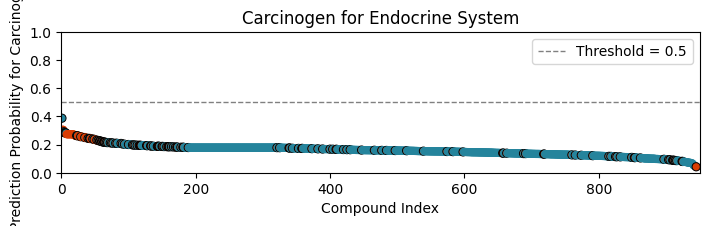

In [ ]:
# Define colors based on the actual value (Yen)
# Red if actual value is 1, blue if actual value is 0
colors = ['#d93d04' if actual == 1 else '#25849c' for actual in Endocrine_sorted['Endocrine system']]

# Identify the indices where the actual and predicted values differ
ENdiff_indices = Endocrine_sorted['Endocrine system'] != Endocrine_sorted['Predicted']

plt.figure(figsize=(7, 2))

# Scatter plot
plt.scatter(
    Endocrine_sorted.index+1,
    Endocrine_sorted['Predict_Prob_Class_1'],
    marker='o', c=colors, s=35,
    edgecolors=np.where(ENdiff_indices, 'black', 'none'),   # Black outline for differing points
    linewidths=0.7
)

# Add horizontal dashed line for threshold
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label="Threshold = 0.5")

plt.xlim(0, 950)
plt.ylim(0, 1)
plt.tight_layout()

plt.xlabel("Compound Index")
plt.ylabel("Prediction Probability for Carcinogen")
plt.title("Carcinogen for Endocrine System")
plt.legend()

plt.savefig("Carcinogen_FQSAR_EN.png", dpi=400)
plt.show()
plt.close()

In [ ]:
ENdiff_indices.value_counts()

False    819
True     126
Name: count, dtype: int64

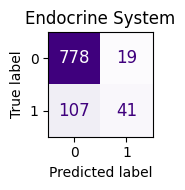

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# True and predicted labels
y_true = Endocrine['Endocrine system']
y_pred = Endocrine['Predicted']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# get the class labels in the order used by the model
labels = SVC_model_endocrine.classes_

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, cmap=plt.cm.Purples, colorbar=False, text_kw={"fontsize": 12})
ax.set_title("Endocrine System")
plt.tight_layout()

# Save to file
fig.savefig('F1confusion_matrix_EN.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Exocrine system
Best model: KNN; Optimal fingerprint: RDKit+Tox21;

No SMOTE was applied during training

F1 = 0.88

In [ ]:
KNN_model_exocrine = load("KNN_noSMOTE_EX_RDKit.joblib")

# Making predictions
y_pred_exocrine = KNN_model_exocrine.predict(X_rdkitTOX)
# Probability predictions (if needed)
y_prob_exocrine = KNN_model_exocrine.predict_proba(X_rdkitTOX)

In [ ]:
Yex_actual = df_finalized.loc[:, ['CAS', 'PubChemCID','Exocrine system']]

# Ensure y_pred_exocrine are DataFrames
y_pred_exocrine = pd.Series(y_pred_exocrine, name="Predicted")
# Convert y_prob_endocrine_class_1 to a Pandas Series
y_prob_exocrine_class_1 = pd.Series(y_prob_exocrine[:, 1], name="Predict_Prob_Class_1")

# Concatenate the DataFrames
Exocrine = pd.concat([Yex_actual, y_pred_exocrine, y_prob_exocrine_class_1], axis=1)

In [ ]:
# Rearrange 'Exocrine' by the column 'Predict_Prob_Class_1' in ascending order
Exocrine_sorted = Exocrine.sort_values(by="Predict_Prob_Class_1", ascending=False)

# Reset the index if needed
Exocrine_sorted = Exocrine_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print(Exocrine_sorted)

           CAS  PubChemCID  Exocrine system  Predicted  Predict_Prob_Class_1
0     122-34-9        5216                1          1                   1.0
1     886-50-0       13450                1          1                   1.0
2    1912-24-9        2256                1          1                   1.0
3      96-13-9        7281                1          1                   1.0
4    3296-90-0       18692                1          1                   1.0
..         ...         ...              ...        ...                   ...
940  4680-78-8       20803                0          0                   0.0
941   470-82-6        2758                0          0                   0.0
942  4759-48-2     5282379                0          0                   0.0
943  4998-76-9     2723770                0          0                   0.0
944   999-81-5       13836                0          0                   0.0

[945 rows x 5 columns]


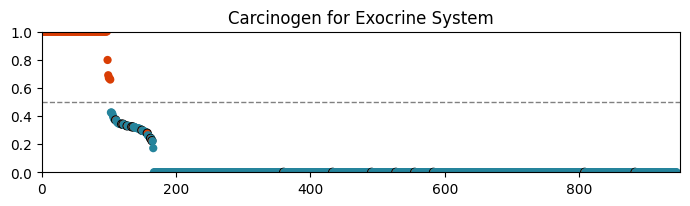

In [ ]:
# Define colors based on the actual value (Yex)
# Red if actual value is 1, blue if actual value is 0
colors = ['#d93d04' if actual == 1 else '#25849c' for actual in Exocrine_sorted['Exocrine system']]

# Identify the indices where the actual and predicted values differ
EXdiff_indices = Exocrine_sorted['Exocrine system'] != Exocrine_sorted['Predicted']

plt.figure(figsize=(7, 2))

# Scatter plot
plt.scatter(
    Exocrine_sorted.index+1,
    Exocrine_sorted['Predict_Prob_Class_1'],
    marker='o',
    c=colors,
    s=35,
    edgecolors=np.where(EXdiff_indices, 'black', 'none'),   # Black outline for differing points
    linewidths=0.7
)

# Add horizontal dashed line for threshold
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label="Threshold = 0.5")

plt.xlim(0, 950)
plt.ylim(0, 1)
plt.tight_layout()

plt.title("Carcinogen for Exocrine System")

plt.savefig("Carcinogen_EX.png", dpi=400)
plt.show()
plt.close()

In [ ]:
EXdiff_indices.value_counts()

False    927
True      18
Name: count, dtype: int64

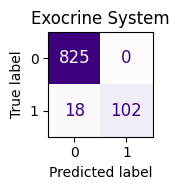

In [ ]:
# True and predicted labels
y_true = Exocrine['Exocrine system']
y_pred = Exocrine['Predicted']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# get the class labels in the order used by the model
labels = KNN_model_exocrine.classes_

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, cmap=plt.cm.Purples, colorbar=False, text_kw={"fontsize": 12})
ax.set_title("Exocrine System")
plt.tight_layout()

# Save to file
fig.savefig('F1confusion_matrix_EX.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Hepatobiliary system
Best model: NN;
Optimal fingerprint: All_included+Tox21;

F1 = 0.68

In [ ]:
model_folder = './Best_NNmodel'

In [ ]:
# Load the model
model_filename = f"Best_NNmodel_All_HE51126.keras"
best_model_hepa = load_model(os.path.join(model_folder, model_filename))

# Print architecture summary
best_model_hepa.summary()

/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 732)            │     1,818,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 232)            │       170,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 232)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 394)            │        91,802 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 394)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           395 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,161,084 (15.87 MB)

 Trainable params: 2,080,541 (7.94 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,080,543 (7.94 MB)

In [ ]:
# Probability predictions
y_prob_hepa = best_model_hepa.predict(X_AllTOX)
# Making predictions
y_pred_hepa = (y_prob_hepa > 0.5).astype("int32")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
Yhe_actual = df_finalized.loc[:, ['CAS', 'PubChemCID','Hepatobiliary system']]

# Flatten to 1D array
y_pred_hepa = y_pred_hepa.ravel()
y_prob_hepa = y_prob_hepa.ravel()

# Ensure y_pred_hepa and y_prob_hepa are DataFrames
y_pred_hepa = pd.Series(y_pred_hepa, name="Predicted")
y_prob_hepa = pd.Series(y_prob_hepa, name="Predict_Prob_Class_1")

# Concatenate the DataFrames
Hepatobiliary = pd.concat([Yhe_actual, y_pred_hepa, y_prob_hepa], axis=1)

In [ ]:
# Rearrange 'Hepatobiliary' by the column 'Predict_Prob_Class_1' in ascending order
Hepatobiliary_sorted = Hepatobiliary.sort_values(by="Predict_Prob_Class_1", ascending=False)

# Reset the index if needed
Hepatobiliary_sorted = Hepatobiliary_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print(Hepatobiliary_sorted)

            CAS  PubChemCID  Hepatobiliary system  Predicted  \
0    77501-63-4       62276                     1          1   
1    50594-66-6       44073                     1          1   
2    42874-03-3       39327                     1          1   
3    62476-59-9       44072                     1          1   
4       97-56-3        7340                     1          1   
..          ...         ...                   ...        ...   
940     54-42-2        5905                     0          0   
941    121-54-0        8478                     0          0   
942    959-24-0       66245                     0          0   
943   6533-68-2    20055509                     0          0   
944    122-60-1       31217                     0          0   

     Predict_Prob_Class_1  
0                0.890770  
1                0.888561  
2                0.877136  
3                0.865454  
4                0.863090  
..                    ...  
940              0.065472  
941    

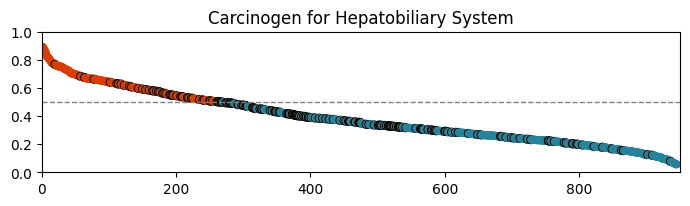

In [ ]:
# Define colors based on the actual value (Yhe)
# Red if actual value is 1, blue if actual value is 0
colors = ['#d93d04' if actual == 1 else '#25849c' for actual in Hepatobiliary_sorted['Hepatobiliary system']]

# Identify the indices where the actual and predicted values differ
HEdiff_indices = Hepatobiliary_sorted['Hepatobiliary system'] != Hepatobiliary_sorted['Predicted']

plt.figure(figsize=(7, 2))

# Scatter plot
plt.scatter(
    Hepatobiliary_sorted.index+1,
    Hepatobiliary_sorted['Predict_Prob_Class_1'],
    marker='o', c=colors, s=35,
    edgecolors=np.where(HEdiff_indices, 'black', 'none'),   # Black outline for differing points
    linewidths=0.7
)

# Add horizontal dashed line for threshold
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label="Threshold = 0.5")

plt.xlim(0, 950)
plt.ylim(0, 1)
plt.tight_layout()

plt.title("Carcinogen for Hepatobiliary System")

plt.savefig("Carcinogen_QSAR_HE.png", dpi=400)
plt.show()
plt.close()

In [ ]:
HEdiff_indices.value_counts()

False    758
True     187
Name: count, dtype: int64

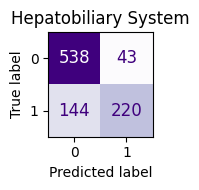

In [ ]:
# True and predicted labels
y_true = Hepatobiliary['Hepatobiliary system']
y_pred = Hepatobiliary['Predicted']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# get the class labels in the order used by the model
labels = np.unique(y_true)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, cmap=plt.cm.Purples, colorbar=False, text_kw={"fontsize": 12})
ax.set_title("Hepatobiliary System")
plt.tight_layout()

# Save to file
fig.savefig('F1confusion_matrix_HE.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Respiratory system
Best model: NN; Optimal fingerprint: FCFP;

ROC-AUC = 0.86

In [ ]:
model_folder = './Best_QSARmodel'

In [ ]:
# Load the model
model_filename = f"best_QSARmodel_FCFP_RES51126.keras"
best_model_res = load_model(os.path.join(model_folder, model_filename))

# Print architecture summary
best_model_res.summary()

/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 74)             │        75,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 476)            │        35,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 476)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           477 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,083 (1.28 MB)

 Trainable params: 112,027 (437.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 224,056 (875.22 KB)

In [ ]:
# Probability predictions
y_prob_res = best_model_res.predict(X_FCFP6)
# Making predictions
y_pred_res = (y_prob_res > 0.5).astype("int32")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
Yres_actual = df_finalized.loc[:, ['CAS', 'PubChemCID','Respiratory system']]

# Flatten to 1D array
y_pred_res = y_pred_res.ravel()
y_prob_res = y_prob_res.ravel()

# Ensure y_pred_res and y_prob_res are DataFrames
y_pred_res = pd.Series(y_pred_res, name="Predicted")
y_prob_res = pd.Series(y_prob_res, name="Predict_Prob_Class_1")

# Concatenate the DataFrames
Respiratory = pd.concat([Yres_actual, y_pred_res, y_prob_res], axis=1)

In [ ]:
# Rearrange 'Respiratory' by the column 'Predict_Prob_Class_1' in ascending order
Respiratory_sorted = Respiratory.sort_values(by="Predict_Prob_Class_1", ascending=False)

# Reset the index if needed
Respiratory_sorted = Respiratory_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print(Respiratory_sorted)

             CAS  PubChemCID  Respiratory system  Predicted  \
0       621-64-7       12130                   1          1   
1       106-87-6        7833                   1          1   
2        62-75-9        6124                   1          1   
3     20917-49-1       30360                   1          1   
4       924-16-3       13542                   1          1   
..           ...         ...                 ...        ...   
940   33229-34-4       36383                   0          0   
941  335104-84-2    11556911                   0          0   
942   34123-59-6       36679                   0          0   
943      62-55-5     2723949                   0          0   
944    2385-85-5       16945                   0          0   

     Predict_Prob_Class_1  
0            1.000000e+00  
1            1.000000e+00  
2            1.000000e+00  
3            1.000000e+00  
4            1.000000e+00  
..                    ...  
940          2.097432e-01  
941          2.0974

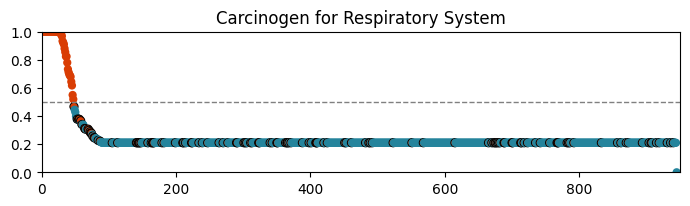

In [ ]:
# Define colors based on the actual value (Yres)
# Red if actual value is 1, blue if actual value is 0
colors = ['#d93d04' if actual == 1 else '#25849c' for actual in Respiratory_sorted['Respiratory system']]

# Identify the indices where the actual and predicted values differ
RESdiff_indices = Respiratory_sorted['Respiratory system'] != Respiratory_sorted['Predicted']

plt.figure(figsize=(7, 2))

# Scatter plot
plt.scatter(
    Respiratory_sorted.index+1,
    Respiratory_sorted['Predict_Prob_Class_1'],
    marker='o', c=colors, s=35,
    edgecolors=np.where(RESdiff_indices, 'black', 'none'),   # Black outline for differing points
    linewidths=0.7
)

# Add horizontal dashed line for threshold
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label="Threshold = 0.5")

plt.xlim(0, 950)
plt.ylim(0, 1)
plt.tight_layout()

plt.title("Carcinogen for Respiratory System")

plt.savefig("Carcinogen_QSAR_RES.png", dpi=400)
plt.show()
plt.close()

In [ ]:
RESdiff_indices.value_counts()

False    823
True     122
Name: count, dtype: int64

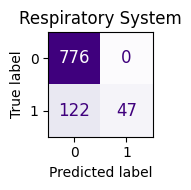

In [ ]:
# True and predicted labels
y_true = Respiratory['Respiratory system']
y_pred = Respiratory['Predicted']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# get the class labels in the order used by the model
labels = np.unique(y_true)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, cmap=plt.cm.Purples, colorbar=False, text_kw={"fontsize": 12})
ax.set_title("Respiratory System")
plt.tight_layout()

# Save to file
fig.savefig('F1confusion_matrix_RES.png',
            dpi=300, bbox_inches='tight')
plt.show()

# Urinary system
Best model: NN; Optimal fingerprint: All;

F1 = 0.84

In [ ]:
# Load the model
model_filename = f"best_QSARmodel_All_U51126.keras"
best_model_urinary = load_model(os.path.join(model_folder, model_filename))

# Print architecture summary
best_model_urinary.summary()

/home/chen.chiyun/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 916)            │     2,210,308 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 104)            │        95,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 474)            │        49,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 474)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           475 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,711,844 (17.97 MB)

 Trainable params: 2,355,921 (8.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,355,923 (8.99 MB)

In [ ]:
# Probability predictions
y_prob_urinary = best_model_urinary.predict(X_All)
# Making predictions
y_pred_urinary = (y_prob_urinary > 0.5).astype("int32")

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [ ]:
Yu_actual = df_finalized.loc[:, ['CAS', 'PubChemCID','Urinary system']]

# Flatten to 1D array
y_pred_urine = y_pred_urinary.ravel()
y_prob_urine = y_prob_urinary.ravel()

# Ensure y_pred_res and y_prob_res are DataFrames
y_pred_urine = pd.Series(y_pred_urine, name="Predicted")
y_prob_urine = pd.Series(y_prob_urine, name="Predict_Prob_Class_1")

# Concatenate the DataFrames
Urinary = pd.concat([Yu_actual, y_pred_urine, y_prob_urine], axis=1)

In [ ]:
# Rearrange 'Urinary' by the column 'Predict_Prob_Class_1' in ascending order
Urinary_sorted = Urinary.sort_values(by="Predict_Prob_Class_1", ascending=False)

# Reset the index if needed
Urinary_sorted = Urinary_sorted.reset_index(drop=True)

# Display the sorted DataFrame
print(Urinary_sorted)

            CAS  PubChemCID  Urinary system  Predicted  Predict_Prob_Class_1
0     3817-11-6       19665               1          1              0.925273
1       90-43-7        7017               1          1              0.881657
2     1116-54-7       14223               1          1              0.830820
3      126-72-7       31356               1          1              0.825834
4       55-18-5        5921               1          1              0.795165
..          ...         ...             ...        ...                   ...
940     64-77-7        5505               0          0              0.000725
941  68844-77-9        2247               0          0              0.000716
942  54143-56-5       41022               0          0              0.000671
943     50-55-5        5770               0          0              0.000542
944  22260-51-1       31100               0          0              0.000492

[945 rows x 5 columns]


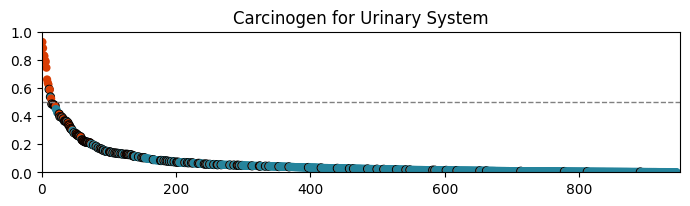

In [ ]:
# Define colors based on the actual value (Yu)
# Red if actual value is 1, blue if actual value is 0
colors = ['#d93d04' if actual == 1 else '#25849c' for actual in Urinary_sorted['Urinary system']]

# Identify the indices where the actual and predicted values differ
Udiff_indices = Urinary_sorted['Urinary system'] != Urinary_sorted['Predicted']

plt.figure(figsize=(7, 2))

# Scatter plot
plt.scatter(
    Urinary_sorted.index+1,
    Urinary_sorted['Predict_Prob_Class_1'],
    marker='o',
    c=colors,
    s=35,
    edgecolors=np.where(Udiff_indices, 'black', 'none'),   # Black outline for differing points
    linewidths=0.7
)

# Add horizontal dashed line for threshold
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, label="Threshold = 0.5")

plt.xlim(0, 950)
plt.ylim(0, 1)
plt.tight_layout()

plt.title("Carcinogen for Urinary System")

plt.savefig("Carcinogen_QSAR_U.png", dpi=400)
plt.show()
plt.close()

In [ ]:
Udiff_indices.value_counts()

False    807
True     138
Name: count, dtype: int64

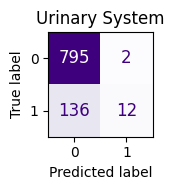

In [ ]:
# True and predicted labels
y_true = Urinary['Urinary system']
y_pred = Urinary['Predicted']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# get the class labels in the order used by the model
labels = np.unique(y_true)

# Create display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot
fig, ax = plt.subplots(figsize=(2, 2))
disp.plot(ax=ax, cmap=plt.cm.Purples, colorbar=False, text_kw={"fontsize": 12})
ax.set_title("Urinary System")
plt.tight_layout()

# Save to file
fig.savefig('F1confusion_matrix_U.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Concatenate all dataFrames
Best_results = pd.concat([Endocrine_sorted, Exocrine_sorted, Hepatobiliary_sorted, Respiratory_sorted, Urinary_sorted], axis=1)
Best_results.info()
Best_results.to_csv('Best_F1results.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CAS                   945 non-null    object 
 1   PubChemCID            945 non-null    int64  
 2   Endocrine system      945 non-null    int64  
 3   Predicted             945 non-null    int64  
 4   Predict_Prob_Class_1  945 non-null    float64
 5   CAS                   945 non-null    object 
 6   PubChemCID            945 non-null    int64  
 7   Exocrine system       945 non-null    int64  
 8   Predicted             945 non-null    int64  
 9   Predict_Prob_Class_1  945 non-null    float64
 10  CAS                   945 non-null    object 
 11  PubChemCID            945 non-null    int64  
 12  Hepatobiliary system  945 non-null    int64  
 13  Predicted             945 non-null    int32  
 14  Predict_Prob_Class_1  945 non-null    float32
 15  CAS                   9

In [ ]:
# make sure output folder exists
os.makedirs("Best", exist_ok=True)

# SHAP analysis

In [ ]:
!pip install shap
import shap
from sklearn.model_selection import train_test_split

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# 1. Gather models in the same order
Models = [
    best_model_hepa,        # HE × All_included+Tox21
    best_model_res,         # RES × FCFP
    best_model_urinary      # U  × All_included
]

# 2. label lists
label_types = ["HE", "RES", "U"]
labels = [Yhe, Yres, Yu]

feature_types = ["All_included+Tox21", "FCFP6", "All_included"]
features = [X_AllTOX, X_FCFP6, X_All]

# 3. Initialize interactive JS
shap.initjs()

# 4. Loop over tasks
for model, X, y, f_name, l_name in zip(Models, features, labels, feature_types, label_types):
    print(f"\nRunning SHAP for {l_name} model (features: {f_name})")

    # a) Split into train/test
    X_train, X_res, y_train, y_res = train_test_split(X, y, train_size=0.7, random_state=42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=42)

    # b) Choose a small background set for explainers that need it
    background = shap.sample(X_train, 80, random_state=42)

    # c) Keras/TensorFlow NN
    explainer = shap.DeepExplainer(model, background.values if hasattr(background, "values") else background)
    shap_vals = explainer.shap_values(X_test.values if hasattr(X_test, "values") else X_test)

    # d) Plot a global summary for the positive class (index 1)
    sv = shap_vals[:, :, 0]          #shap_vals is a single array with shape: (142, 2483, 1) → (142, 2483)
    shap.summary_plot(sv, X_test, max_display=10, show=False)

    # d) Save the figure
    fig = plt.gcf()
    fig.set_size_inches(5, 4)
    fig.savefig(f"Best/shap_summary_{l_name}_{f_name}.png", dpi=500, bbox_inches="tight")
    plt.close(fig)
    print(f"→ saved")


Running SHAP for HE model (features: All_included+Tox21)


/home/chen.chiyun/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


→ saved

Running SHAP for RES model (features: FCFP6)


/home/chen.chiyun/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


→ saved

Running SHAP for U model (features: All_included)


/home/chen.chiyun/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


→ saved


# SHAP for Endocrine system

In [ ]:
# Initialize interactive JS
shap.initjs()

# Split into train/test for this endpoint
X_train, X_test, y_train, y_test = train_test_split(X_All, Yen, test_size=0.2, random_state=42, stratify=Yen)
# b) Choose a small background set for explainers that need it
background = shap.sample(X_train, 80, random_state=42)

# c) Keras/TensorFlow NN
explainer = shap.KernelExplainer(SVC_model_endocrine.predict_proba, background)
shap_vals = explainer.shap_values(X_test)

# d) Plot a global summary for the positive class (index 1)
sv = shap_vals[:, :, 1]          #shap_vals is a single array with shape: (189, 2412, 2) → (189, 2412)
shap.summary_plot(sv, X_test, max_display=10, show=False)

# e) Save the figure
fig = plt.gcf()
fig.set_size_inches(5, 4)
fig.savefig("Best/shap_summary_EN_All.png", dpi=500, bbox_inches="tight")

plt.close(fig)
print(f"→ saved")

In [ ]:
# right after explainer.shap_values(...)
print("X_test shape:", X_test.shape)

# shap_vals might be a single array or a list of arrays
if isinstance(shap_vals, list):
    print("shap_vals is a list of", len(shap_vals), "arrays, with shapes:",
          [arr.shape for arr in shap_vals])
else:
    print("shap_vals is a single array with shape:", shap_vals.shape)

# SHAP for Exocrine system

In [ ]:
# Initialize interactive JS
shap.initjs()

# Split into train/test for this endpoint
X_train, X_test, y_train, y_test = train_test_split(X_rdkitTOX, Yex, test_size=0.2, random_state=42, stratify=Yex)
# b) Choose a small background set for explainers that need it
background = shap.sample(X_train, 80, random_state=42)

# c) Keras/TensorFlow NN
explainer = shap.KernelExplainer(KNN_model_exocrine.predict_proba, background)
shap_vals = explainer.shap_values(X_test)

# d) Plot a global summary for the positive class (index 1)
sv = shap_vals[:, :, 1]          #shap_vals is a single array with shape: (189, 268, 2) → (189, 268)
shap.summary_plot(sv, X_test, max_display=10, show=False)

# e) Save the figure
fig = plt.gcf()
fig.set_size_inches(5, 4)
fig.savefig("Best/shap_summary_EX_RDKitTOXF1.png", dpi=500, bbox_inches="tight")

plt.close(fig)
print(f"→ saved")

# Other plots

In [ ]:
# Gather models in the same order as feature/label lists
models = [
    SVC_model_endocrine,    # EN × All_included
    KNN_model_exocrine,     # EX × RDKit+Tox21
    best_model_hepa,        # HE × All_included+Tox21
    best_model_res,         # RES × FCFP
    best_model_urinary      # U  × All_included
]

# feature & label lists
feature_types = ["All_included", "RDKit+Tox21", "All_included+Tox21", "FCFP", "All_included"]
label_types = ["EN", "EX", "HE", "RES", "U"]

features = [X_All, X_rdkitTOX, X_AllTOX, X_FCFP6, X_All]
labels = [Yen, Yex, Yhe, Yres, Yu]

# Feature Permutation Analysis

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

# 1) Define a tiny sklearn wrapper for your Keras net
class NNWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, classes=None):
        self.model = model
        # set up classes_ so roc_auc scoring will work
        self.classes_ = np.array(classes) if classes is not None else np.array([0, 1])
        self._estimator_type = "classifier"

    def fit(self, X, y):
        # no-op: assume your Keras model is already trained
        return self

    def predict(self, X):
        # binary threshold at 0.5
        proba = self.model.predict(X, verbose=0).ravel()
        return (proba >= 0.5).astype(int)

    def predict_proba(self, X):
        proba = self.model.predict(X, verbose=0).ravel()
        # return shape (n_samples, 2)
        return np.vstack([1-proba, proba]).T

In [ ]:
from sklearn.inspection import permutation_importance

# Initialize an empty list to collect all feature importance data
all_features = []

# Loop over each label type directly from the results
for model, X, y, f_name, l_name in zip(models, features, labels, feature_types, label_types):
    # 1) split (custom for RES)
    if l_name in ("HE", "RES", "U"):
        X_train, X_res, y_train, y_res = train_test_split(
            X, y, train_size=0.7, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(
            X_res, y_res, test_size=0.5, random_state=42)
    else:
        _, X_test, _, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

    # Determine feature importance
    # for NN models, wrap it so roc_auc will work
    if l_name in ("HE", "RES", "U"):
        wrapped = NNWrapper(model)
        estimator = wrapped
    else:
        estimator = model

    perm = permutation_importance(estimator, X_test, y_test,
            scoring='f1_weighted', n_repeats=10, random_state=42)
    importance = perm.importances_mean

    # Create DataFrame for feature importance
    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Select Top 10 Features
    top_10_df = importance_df.head(10).copy()

    # Add model information to DataFrame
    top_10_df['Algorithm'] = model
    top_10_df['Label_Type'] = l_name
    top_10_df['Feature_Type'] = f_name

    # Append to master list
    all_features.append(top_10_df)

    # Plot top 10 feature importance
    plt.figure(figsize=(4, 3))
    plt.barh(top_10_df['Feature'], top_10_df['Importance'], color='teal')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'{l_name} on {f_name}')
    plt.gca().invert_yaxis()  # Reverse order for better readability
    plt.tight_layout()    #(3.2, 2.9) for HE

    fig.subplots_adjust(left=0.35, right=0.95, top=0.95, bottom=0.05)  # lock in your axes rectangle

    # Save the plot
    plt.savefig(f"Best/FTop10_Feature_Importance_{l_name}.png", dpi=500, bbox_inches="tight")
    print(f"saved {l_name} in folder: Best")
    plt.close()

# Combine all top 10 features into one CSV
combined_df = pd.concat(all_features, axis=0)
combined_df.to_csv(f"Best/F1_Top10_Features.csv", index=False)

print(f"All results saved in folder: Best")

saved EN in folder: Best
saved EX in folder: Best
saved HE in folder: Best
saved RES in folder: Best
saved U in folder: Best
All results saved in folder: Best


# ROC-AUC Curves

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# colors map
label_colors = {
    'EN':  '#c77dff',
    'EX':  '#9d6b53',
    'HE':  '#ffd60a',
    'RES': '#fc6a58',
    'U':   '#0d3b66'
}

# prepare two figures
fig_roc, ax_roc = plt.subplots(figsize=(4.6, 3.8))
fig_pr, ax_pr   = plt.subplots(figsize=(4.6, 3.8))

# loop through five tasks
for model, X, y, f_name, l_name in zip(models, features, labels, feature_types, label_types):
    # 1) split
    if l_name.strip() in ("HE", "RES", "U"):
        X_train, X_res, y_train, y_res = train_test_split(
            X, y, train_size=0.7, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(
            X_res, y_res, test_size=0.5, random_state=42)
    else:
        _, X_test, _, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

    # 2) get positive-class probability
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.predict(X_test).ravel()

    # 3) ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    ax_roc.plot(
        fpr, tpr,
        color=label_colors.get(l_name, "black"),
        lw=2, label=f"{l_name} (AUC={roc_auc:.2f})")

    # 4) PR
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    ax_pr.plot(
        recall, precision,
        color=label_colors.get(l_name, "black"),
        lw=2, label=f"{l_name} (AUC={pr_auc:.2f})")

# finalize ROC plot
ax_roc.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=1)
ax_roc.set_title("ROC Curves for All Endpoints")
ax_roc.set_xlabel("False Positive Rate")
ax_roc.set_ylabel("True Positive Rate")
ax_roc.legend(loc="lower right")
fig_roc.savefig("Best/F1_ROC.png", dpi=500, bbox_inches="tight")
plt.close(fig_roc)

# finalize PR plot
ax_pr.plot([0, 1], [1, 0], color="gray", linestyle="--", lw=1)
ax_pr.set_title("Precision–Recall Curves for All Endpoints")
ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")
ax_pr.legend(loc="upper right")
fig_pr.savefig("Best/F1_PR.png", dpi=500, bbox_inches="tight")
plt.close(fig_pr)

print("Saved Best/F1_ROC.png and Best/F1_PR.png.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Saved Best/F1_ROC.png and Best/F1_PR.png.


# Bar plots for predicted prob

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


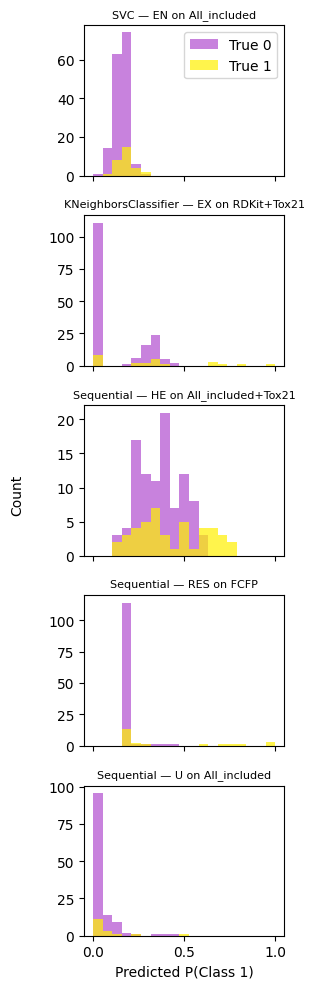

In [ ]:
# define your bins and colors
bins   = np.linspace(0, 1, 20)
colors = {"Class 0":"#B14DCF","Class 1":"#FFF000"}

# 3. Create the figure with 5 subplots (one per model)
fig, axes = plt.subplots(
    nrows=len(models), ncols=1,
    figsize=(3, 2 * len(models)),
    sharex=True, sharey=False
)

for ax, model, X, y, f_name, l_name in zip(
        axes, models, features, labels, feature_types, label_types):

    # a) train/test split
    if l_name in ("EN", "EX"):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    else:
        X_train, X_res, y_train, y_res = train_test_split(X, y, train_size=0.7, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_res, y_res, test_size=0.5, random_state=42)

    # b) get positive-class probability
    if hasattr(model, "predict_proba"):
        prob_pos = model.predict_proba(X_test)[:, 1]
    else:
        prob_pos = model.predict(X_test).ravel()

    # c) split by true class
    prob_class_0 = prob_pos[y_test == 0]
    prob_class_1 = prob_pos[y_test == 1]

    # d) plot on its own axis
    ax.hist(prob_class_0, bins=bins, color=colors["Class 0"], alpha=0.7, label="True 0")
    ax.hist(prob_class_1, bins=bins, color=colors["Class 1"], alpha=0.7, label="True 1")

    ax.set_title(f"{model.__class__.__name__} — {l_name} on {f_name}", fontsize=8)

    # only add legend on the first subplot
    if ax is axes[0]:
        ax.legend(loc="upper right")

axes[-1].set_xlabel("Predicted P(Class 1)")
fig.supylabel("Count", fontsize=10)
fig.tight_layout()

fig.savefig("Best/F1_Prob_Distributions.png", dpi=500, bbox_inches="tight")
plt.show()